In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF

###### MFS® Meridian Global Equity A1 EUR - ISIN LU0094560744 - Mutual Fund

##### vs

######  iShares Core MSCI World UCITS ETF (IWDA.AS) (LQD)

In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib.ticker import FuncFormatter
from pandas_datareader import data as pdr
from time import gmtime, strftime
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)
pd.set_option("display.max_rows", 20)

# Set matplotlib style
plt.style.use('seaborn')

# Set plotly offline
init_notebook_mode(connected=True)

In [3]:
import cufflinks as cf

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [4]:
a = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('A última vez que este script foi executado foi em:', a)

A última vez que este script foi executado foi em: 2017-10-08 16:33:58


In [5]:
#### Functions ####
def compute_drawdowns(dataframe):
    """
    Function to compute drawdowns of a timeseries
    """
    return (dataframe / dataframe.cummax() -1) * 100

In [6]:
# Downloading funds and creating quotes and returns dataframes
Begin = "2009-10-31"
                           
MSid = ['F0GBR04E6R']
Nomes = ['MFS_GE']
fundos = pd.DataFrame()

# Conversão de datetime
conv = time.strptime(Begin,"%Y-%m-%d") 
start_date = time.strftime("%m/%d/%Y",conv)

# Download
for ticker in MSid:
    url = "https://lt.morningstar.com/api/rest.svc/timeseries_price/okhysb8aoh?id=" + str(ticker) + "&currencyId=BAS&idtype=Morningstar&frequency=daily&startDate=" + start_date + "&outputType=CSV"
    fundo = pd.read_csv(url, sep = ";" , index_col = 'date', parse_dates = True)
    fundo =  fundo.drop('Unnamed: 2', 1)
    fundos = fundos.merge(fundo, left_index = True, right_index = True, how='outer')
    
fundos.columns = Nomes
fundos = fundos.fillna(method='ffill')

In [7]:
fundos.head()

,MFS_GE
date,
2009-11-02,11.07
2009-11-03,11.04
2009-11-04,11.09
2009-11-05,11.25
2009-11-06,11.17


In [8]:
fundos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1971 entries, 2009-11-02 to 2017-10-05
Data columns (total 1 columns):
MFS_GE    1971 non-null float64
dtypes: float64(1)
memory usage: 30.8 KB


In [9]:
# download quotes
tickers = ['IWDA.AS']
Quotes = pd.DataFrame()
Start ='2009-10-31'

for t in tickers:
    Quotes[t] = pdr.get_data_yahoo(t, start=Start)['Adj Close']

In [10]:
Quotes.head()

,IWDA.AS
Date,
2009-11-02,16.549999
2009-11-03,16.520000
2009-11-04,16.680000
2009-11-05,16.740000
2009-11-06,16.790001


In [11]:
Quotes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2032 entries, 2009-11-02 to 2017-10-06
Data columns (total 1 columns):
IWDA.AS    1998 non-null float64
dtypes: float64(1)
memory usage: 31.8 KB


In [12]:
Quotes_df = Quotes.merge(fundos, left_index = True, right_index = True, how='outer')

In [13]:
Quotes_df.head()

,IWDA.AS,MFS_GE
2009-11-02,16.549999,11.07
2009-11-03,16.520000,11.04
2009-11-04,16.680000,11.09
2009-11-05,16.740000,11.25
2009-11-06,16.790001,11.17


In [14]:
Quotes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2042 entries, 2009-11-02 to 2017-10-06
Data columns (total 2 columns):
IWDA.AS    1998 non-null float64
MFS_GE     1971 non-null float64
dtypes: float64(2)
memory usage: 47.9 KB


In [15]:
# Reordering the columns
Quotes_df = Quotes_df[['MFS_GE', 'IWDA.AS']]


In [16]:
Quotes_df = Quotes_df.fillna(method='ffill')

In [17]:
Quotes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2042 entries, 2009-11-02 to 2017-10-06
Data columns (total 2 columns):
MFS_GE     2042 non-null float64
IWDA.AS    2042 non-null float64
dtypes: float64(2)
memory usage: 47.9 KB


In [18]:
#### Returns ####
returns = (Quotes_df / Quotes_df.shift(1)) - 1

In [19]:
#### Normalization to 100 ####
Quotes_df_norm = round((Quotes_df / Quotes_df.iloc[0] * 100), 2)

In [20]:
Quotes_df_norm.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos', title='Performance dos fundos')

In [21]:
#### Computing Drawdowns ####
DD = round(compute_drawdowns(Quotes_df_norm), 2)

DD.iplot(kind='scatter', title='Drawdown dos portfolios', yTitle='Percentagem')

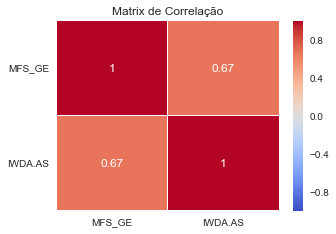

In [22]:
##### New Preturns (to include Portfolio returns) ####
Preturns = (Quotes_df_norm / Quotes_df_norm.shift(1)) - 1

##### Correlation (bonus: Seaborn heatmap)####
Pcorr_matrix = Preturns.corr()
a = -0.5

# Normal heatmap
fig, ax = plt.subplots()
fig.set_size_inches(5, 3.5) # 68%
sns.heatmap(Pcorr_matrix, annot = True, cmap = "coolwarm", linewidths=.2, vmin=-1)
plt.yticks(rotation=360)
plt.title('Matrix de Correlação')
plt.show()

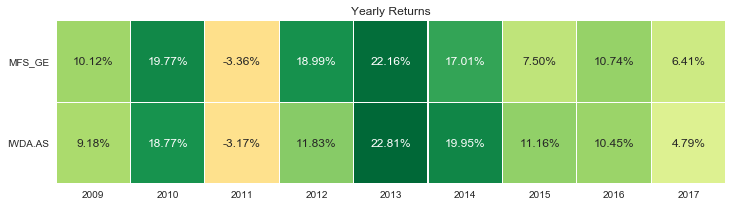

In [23]:
# Resampling to yearly (business year)
yearly_quotes = Quotes_df_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes = pd.concat([Quotes_df_norm.iloc[:1], yearly_quotes])

# Returns
yearly_returns = ((yearly_quotes / yearly_quotes.shift(1)) - 1) * 100
returns = yearly_returns.set_index([list(range(2008, 2018))]).drop(2008)

#### Inverter o sentido das rows no dataframe ####
returns = returns.transpose()

# Yearly returns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(12, 3) # 68%
heatmap = sns.heatmap(returns, annot=True, cmap="RdYlGn", linewidths=.2, fmt=".2f", cbar=False, center=1)
for t in heatmap.texts: t.set_text(t.get_text() + "%")
plt.title('Yearly Returns')
plt.yticks(rotation=360)
plt.show()

In [41]:
Racio = round(Quotes_df_norm['MFS_GE'] / Quotes_df_norm['IWDA.AS'], 4)

In [42]:
Racio.iplot(title = 'Ratio between MFS Global Equity and IWDA')